# Analysis of Insurance Data - Understanding and Predicting User Purchase of Insurance

This report seeks to analyse public insurance data from A Tour & Travels Company (https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data) with the ultimate aim of predicting user purchases of insurance. In doing so, I perform a variety of analyses, from exploratory data analysis, significance-testing and inferential studies into valid coefficients, as well as finally building an array of machine learning models to maximize the predictive value of these models.

This notebook will use the demographic data of users as independent variables to arrive at a point where we can estimate their influence on whether a consumer buys a given product or not (measured in the 'TravelInsurance' column). The independent variables are as follows:
- **Age**. This measures the age of the respondent. This measure is continuous.
- **EmploymentType**. This measures whether a respondent is employed in the government, or in the private sector. This measure is binary.
- **GraduateOrNot**. This measures whether a respondent has graduated from university. This measure is binary.
- **AnnualIncome**. This measures the annual income of a respondent. This measure is continuous.
- **FamilyMembers**. This measures the number of family members a respondent has. This measure is continuous.
- **ChronicDiseases**. This measures if the respondent has a chronic disease. This measure is binary.
- **FrequentFlyer**. This measures if the respondent is a frequent flyer or not. This measure is binary.
- **EverTravelledAbroad**. This measures if the respondent has travelled abroad. This measure is binary.

The hypothesis of the analysis is that the annual income of a person will be the greatest decider of whether someone actually buys the insurance. This is in line with other research i have read, such as from these sources:
- https://www.academia.edu/115821449/An_Analysis_of_the_Effect_of_Income_on_Life_Insurance?utm_source=chatgpt.com
- https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-020-09362-5?utm_source=chatgpt.com
This will manifest it in having the highest coefficient in the inferential logistic regression, and by the various machine learning algorithms indicating it to also have the highest coefficient or measure of importance.

### Relevant Packages

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Data Cleaning

In the source of the dataset, it is mentioned that the data has already been cleaned. I here double check this with a few spot checks.

There seems to be 738 duplicates in the dataset. However, it is entirely possible that these figures are organic duplicates - that is to say that they, for example, are not the same person giving the same information more than once. As such, I will keep these in the dataset.

In [2]:
file = pd.read_csv("Dataset (Travel Insurance Prediction).csv", index_col=0)
file

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0
...,...,...,...,...,...,...,...,...,...
1982,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes,1
1983,28,Private Sector/Self Employed,Yes,1750000,5,1,No,Yes,0
1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0
1985,34,Private Sector/Self Employed,Yes,1000000,6,0,Yes,Yes,1


In [3]:
print("Duplicate rows:", file.duplicated().sum())

Duplicate rows: 738


In [4]:
print("NaN values per column:\n", file.isna().sum())

NaN values per column:
 Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64


In [5]:
file = file.rename(columns={"Employment Type": "EmploymentType"})

In [6]:
file.sample(10)

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
1559,34,Private Sector/Self Employed,Yes,1050000,3,1,No,No,0
998,26,Private Sector/Self Employed,Yes,1400000,4,0,No,Yes,1
1667,28,Private Sector/Self Employed,Yes,750000,5,0,No,No,0
1154,34,Private Sector/Self Employed,Yes,1000000,5,1,No,No,0
574,29,Private Sector/Self Employed,Yes,1150000,5,0,Yes,No,0
1241,33,Government Sector,Yes,1100000,8,0,No,No,1
1265,34,Private Sector/Self Employed,Yes,1000000,5,0,No,No,0
1378,34,Government Sector,Yes,1300000,2,1,No,No,0
100,28,Private Sector/Self Employed,Yes,1300000,6,1,No,No,1
1476,33,Private Sector/Self Employed,Yes,1750000,6,0,No,No,1


In [7]:
unique_values_A = file["GraduateOrNot"].unique()
print("\nUnique values in column 'GraduateOrNot':")
print(unique_values_A)


Unique values in column 'GraduateOrNot':
['Yes' 'No']


In [8]:
unique_values_B = file["FrequentFlyer"].unique()
print("\nUnique values in column 'FrequentFlyer':")
print(unique_values_B)


Unique values in column 'FrequentFlyer':
['No' 'Yes']


In [9]:
unique_values_B = file["EverTravelledAbroad"].unique()
print("\nUnique values in column 'EverTravelledAbroad':")
print(unique_values_B)


Unique values in column 'EverTravelledAbroad':
['No' 'Yes']


In [10]:
unique_values_B = file["ChronicDiseases"].unique()
print("\nUnique values in column 'ChronicDiseases':")
print(unique_values_B)


Unique values in column 'ChronicDiseases':
[1 0]


In [11]:
unique_values_B = file["EmploymentType"].unique()
print("\nUnique values in column 'ChronicDiseases':")
print(unique_values_B)


Unique values in column 'ChronicDiseases':
['Government Sector' 'Private Sector/Self Employed']


In [12]:
def replace_yes_no(value):
    if value == "Yes":
        return 1
    elif value == "No":
        return 0
    else:
        raise ValueError(f"Invalid value: {value}. Expected 'Yes' or 'No'.")


columns_to_replace = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]

for column in columns_to_replace:
    try:
        file[column] = file[column].apply(replace_yes_no)
    except ValueError as e:
        print(f"Error in column '{column}': {e}")

In [13]:
file.sample(10)

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
1813,29,Private Sector/Self Employed,1,1350000,4,0,0,1,1
666,28,Private Sector/Self Employed,1,800000,5,0,0,0,0
677,27,Private Sector/Self Employed,0,450000,7,0,0,0,0
140,28,Private Sector/Self Employed,1,550000,4,1,0,0,0
1516,34,Government Sector,1,1300000,2,0,0,0,0
1190,31,Private Sector/Self Employed,1,1250000,3,0,0,0,0
187,28,Private Sector/Self Employed,1,650000,9,0,0,0,0
537,29,Private Sector/Self Employed,1,600000,8,1,0,0,1
866,31,Private Sector/Self Employed,1,1400000,3,1,0,1,1
1192,33,Government Sector,1,1100000,3,0,0,0,1


# Train-Test Split
First I split the data into a train and test split to ensure that there is no data leakage. I use a stratified split in case the data is skewed, and as I later found out, this was a good idea since there is an imbalance and skewness in many of the features and to a degree also the response variable (36%/64%).

I then merge the columns of our training data to make the EDA and inferential model smoother

In [14]:
X = file.drop("TravelInsurance", axis=1)
y = file["TravelInsurance"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
X_train["TravelInsurance"] = y_train
training_data = X_train

# Exploratory Data Analysis

In [16]:
training_data.describe()

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
count,1589.000000,1589.000000,1.589000e+03,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000
mean,29.604783,0.848962,9.293266e+05,4.757080,0.275016,0.208936,0.187539,0.357458
std,2.913294,0.358199,3.783027e+05,1.606864,0.446663,0.406677,0.390467,0.479402
min,25.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,6.000000e+05,4.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,1.000000,9.000000e+05,5.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.250000e+06,6.000000,1.000000,0.000000,0.000000,1.000000
max,35.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
training_data.dtypes

Age                     int64
EmploymentType         object
GraduateOrNot           int64
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer           int64
EverTravelledAbroad     int64
TravelInsurance         int64
dtype: object

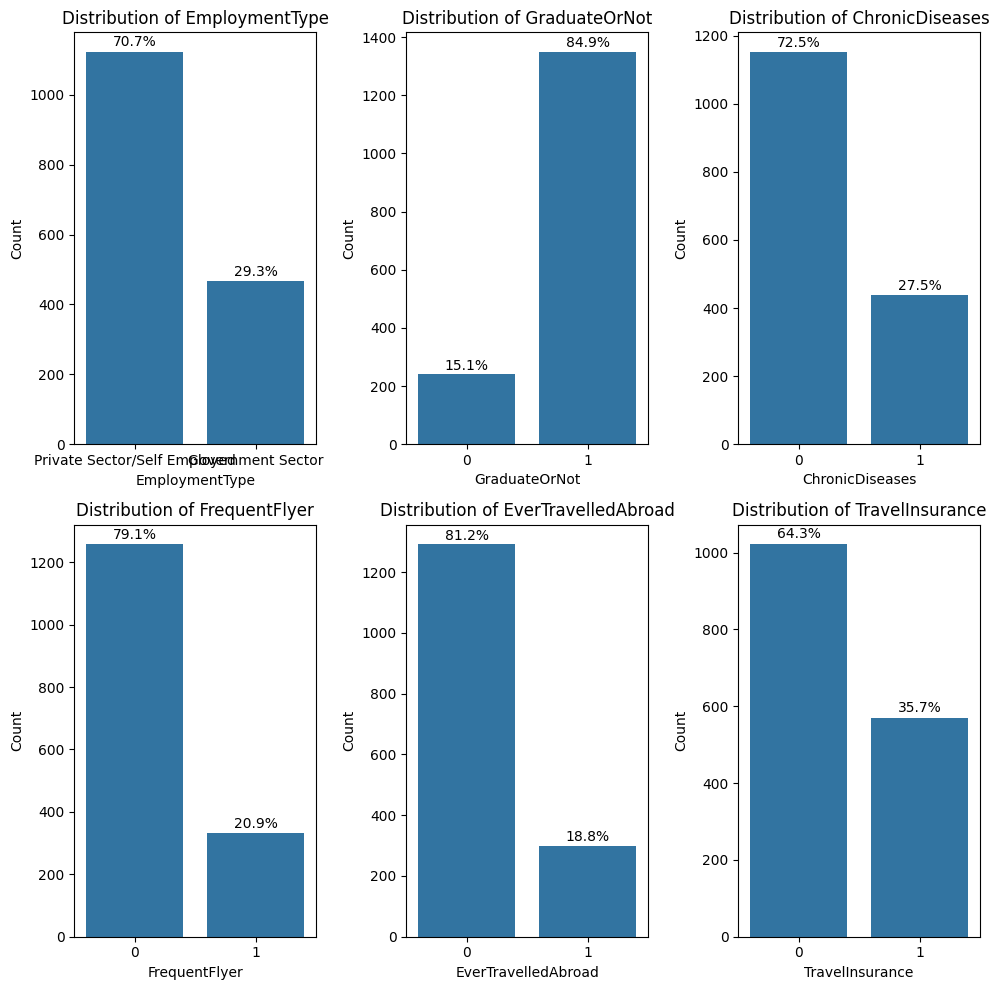

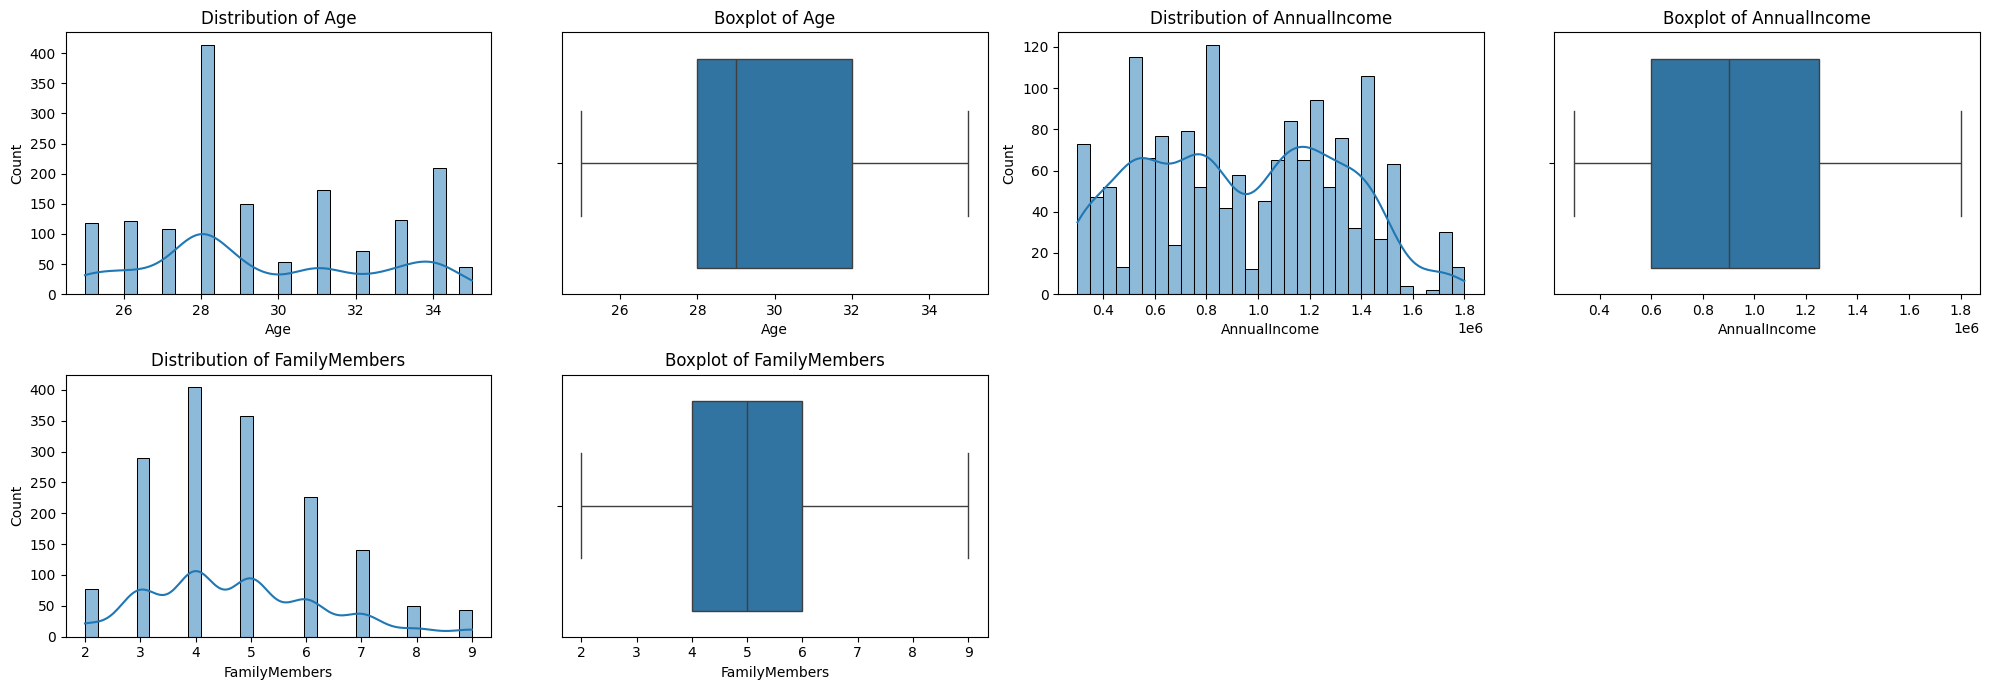

In [18]:
columns_to_plot = [
    "EmploymentType",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "TravelInsurance",
]

plt.figure(figsize=(10, 10))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)

    sns.countplot(x=col, data=training_data)

    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    total = len(training_data)
    for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().text(
            p.get_x() + p.get_width() / 2.0,
            height + 0.01 * total,
            f"{height/total:.1%}",
            ha="center",
        )

plt.tight_layout()
plt.show()

features = ["Age", "AnnualIncome", "FamilyMembers"]
n_cols = 4
n_rows = int(len(features) * 2 / n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3.5))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(training_data[col], kde=True, bins=30, ax=axes[2 * i])
    axes[2 * i].set_title(f"Distribution of {col}")

    sns.boxplot(x=training_data[col], ax=axes[2 * i + 1])
    axes[2 * i + 1].set_title(f"Boxplot of {col}")

for j in range(2 * len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

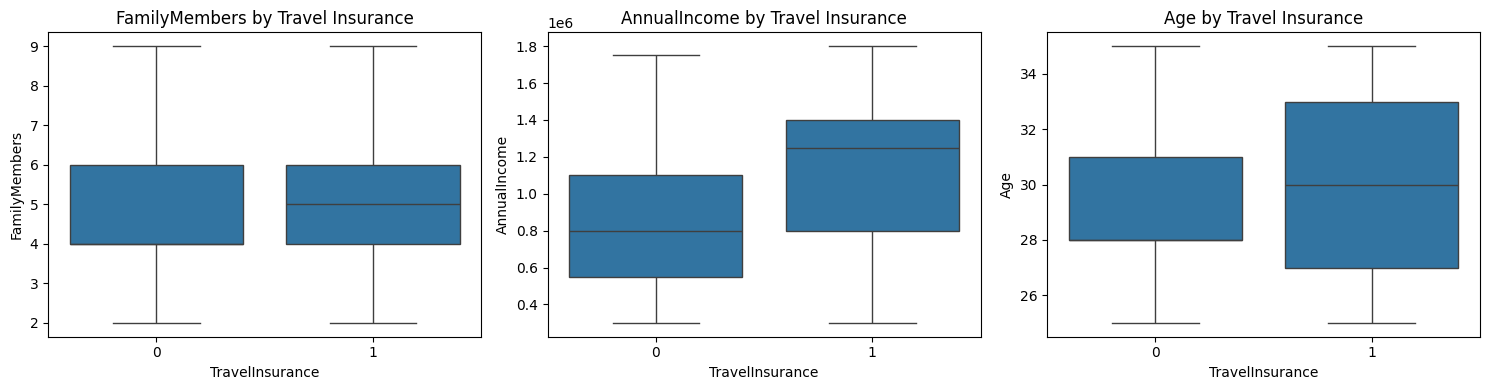

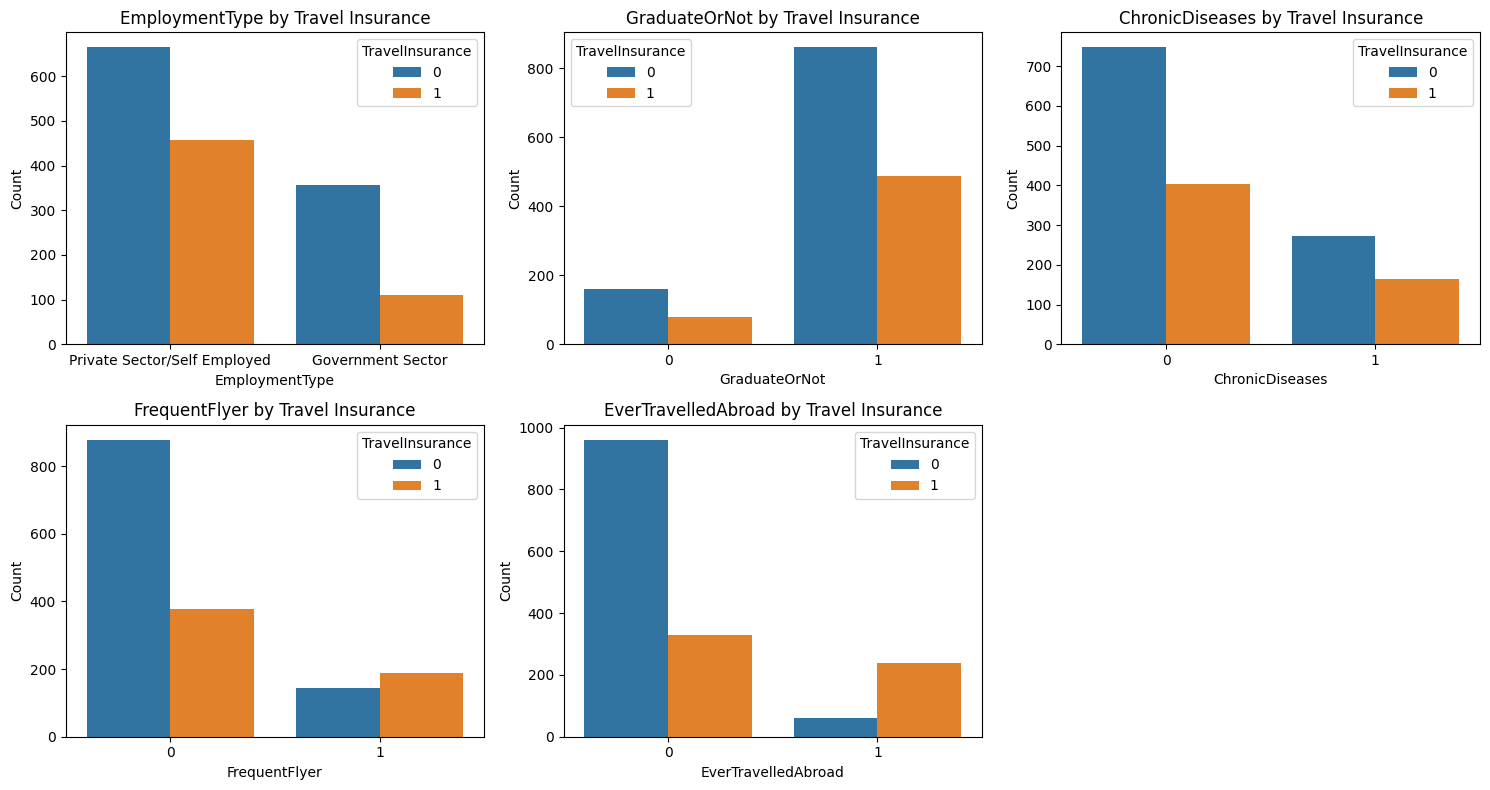

In [19]:
rel_columns = ["FamilyMembers", "AnnualIncome", "Age"]

n_cols = 3
n_rows = (len(rel_columns) // n_cols) + int(len(rel_columns) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(rel_columns):
    sns.boxplot(x="TravelInsurance", y=col, data=training_data, ax=axes[i])
    axes[i].set_title(f"{col} by Travel Insurance")

for j in range(len(rel_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

rel_columns = [
    "EmploymentType",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

n_cols = 3
n_rows = (len(rel_columns) // n_cols) + int(len(rel_columns) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(rel_columns):
    sns.countplot(x=col, hue="TravelInsurance", data=training_data, ax=axes[i])
    axes[i].set_title(f"{col} by Travel Insurance")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(rel_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

## Converting 'EmploymentType' Column to Binary Digits

In [20]:
def replace_yes_no(value):
    if value == "Government Sector":
        return 1
    elif value == "Private Sector/Self Employed":
        return 0
    else:
        raise ValueError(
            f"Invalid value: {value}. Expected 'Government Sector' or 'Private Sector/Self Employed'."
        )


columns_to_replace = ["EmploymentType"]

for column in columns_to_replace:
    try:
        training_data[column] = training_data[column].apply(replace_yes_no)
    except ValueError as e:
        print(f"Error in column '{column}': {e}")

for column in columns_to_replace:
    try:
        X_test[column] = X_test[column].apply(replace_yes_no)
    except ValueError as e:
        print(f"Error in column '{column}': {e}")

## Standardizing the Data
Next I standardize the data so that it can better be studied in an inferential logistic regression.

In [21]:
df = training_data.copy()
continuous_cols = ["Age", "AnnualIncome", "FamilyMembers"]
for col in continuous_cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [22]:
df.sample(10)

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
738,-0.550848,0,1,-0.341860,1.395837,0,1,0,0
651,1.165422,0,1,1.244171,2.018168,1,0,1,1
691,0.478914,0,1,0.054648,-1.093484,0,1,0,0
1434,1.508676,0,1,2.169356,-1.093484,0,1,0,0
1943,-0.207594,0,1,0.318986,-1.715815,0,0,0,0
1857,-0.894102,1,1,-0.077522,-0.471154,0,0,0,0
1445,-0.550848,0,1,0.451156,-0.471154,1,0,0,0
468,-0.550848,0,1,0.715494,0.151177,0,0,0,0
1905,-1.580610,0,0,-0.870537,-0.471154,1,1,0,0
661,-0.550848,1,0,-1.663553,0.151177,0,0,0,0


## Checking for Multicollinearity
Next I create a heat map to see if any different variables are highly correlated. As can be seen, there are a variety of different variables that are notably correlated. This could pose a potential issue, as it can inflate beta coefficients and make it hard to tell which variable is actually influencing our dependent variable of whether someone bought the insurance ('TravelInsurance').

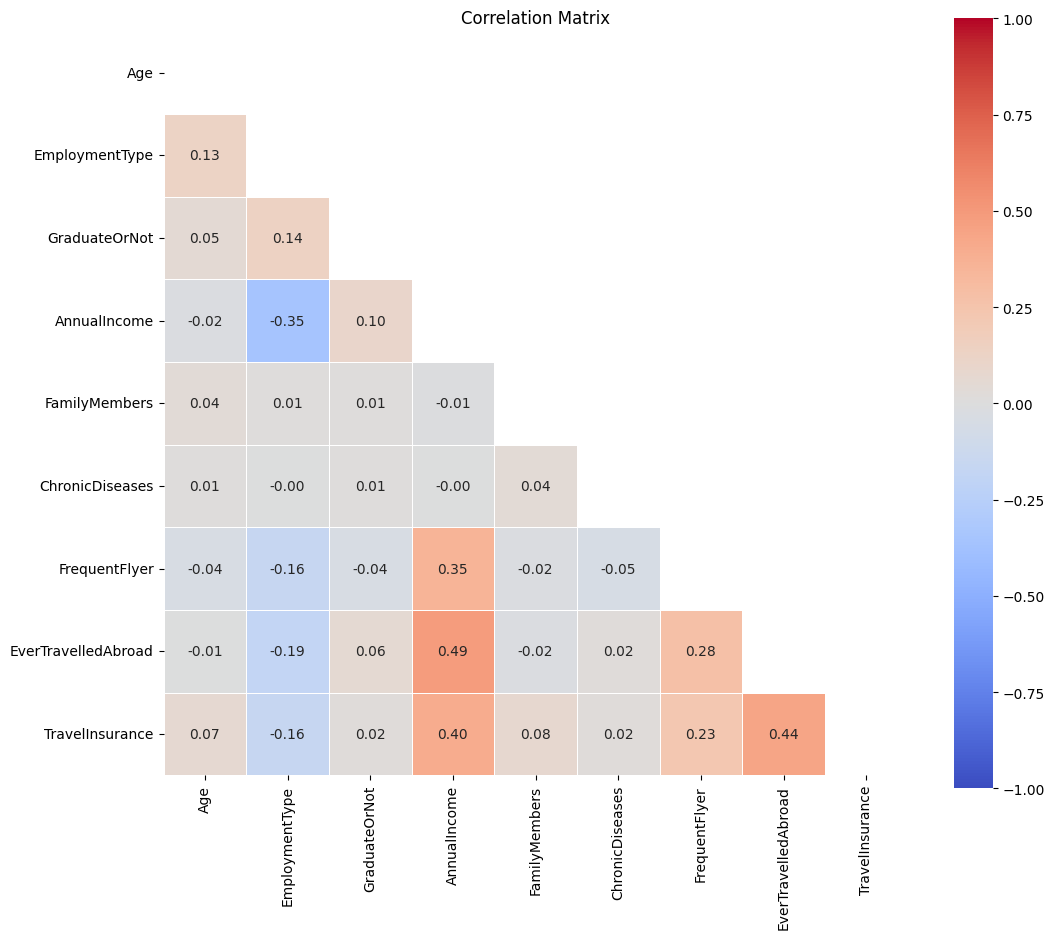

In [23]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix")
plt.show()

## Running a VIF (Variance Inflation Factor) for Multicollinearity
I next run a VIF to see if any of the variables are noticeably correlated. However, as the heat map of Pearsons *r* values above also shows, there are no individual variables which are significantly correlated with one another (e.g., scores between 5-10, or at least around 5).

In [24]:
X = df.drop("TravelInsurance", axis=1)

X_with_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(X_with_const.shape[1])
]

print(vif_data)

              Variable       VIF
0                const  7.912581
1                  Age  1.021192
2       EmploymentType  1.201282
3        GraduateOrNot  1.052802
4         AnnualIncome  1.571582
5        FamilyMembers  1.003902
6      ChronicDiseases  1.005694
7        FrequentFlyer  1.175963
8  EverTravelledAbroad  1.337723


# Running a Logistic Regression to Investigate Coefficients
Next I run a logistic regression to build an inferential model and further understand the validity of each coefficient in later building a predictive model.

In [25]:
formula = "TravelInsurance ~ Age + AnnualIncome + FamilyMembers + EmploymentType + GraduateOrNot + ChronicDiseases + FrequentFlyer + EverTravelledAbroad"

model = logit(formula, data=df).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.516109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        TravelInsurance   No. Observations:                 1589
Model:                          Logit   Df Residuals:                     1580
Method:                           MLE   Df Model:                            8
Date:                Mon, 19 May 2025   Pseudo R-squ.:                  0.2084
Time:                        13:41:42   Log-Likelihood:                -820.10
converged:                       True   LL-Null:                       -1035.9
Covariance Type:            nonrobust   LLR p-value:                 3.112e-88
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.9687      0.169     -5.733      0.000      -1.300      -0.638
Ag

Based on the results, five predictor variables seem to be significant, namely Age, AnnualIncome, FamilyMembers, FrequentFlyer, and EverTravelledAbroad.
As these are the only ones that are significant, I rerun the model without the remaining ones in order to specify the coefficients further.

In [26]:
significant_vars = [
    "Age",
    "AnnualIncome",
    "FamilyMembers",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

formula = "TravelInsurance ~ " + " + ".join(significant_vars)

model = logit(formula, data=df).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.517135
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        TravelInsurance   No. Observations:                 1589
Model:                          Logit   Df Residuals:                     1583
Method:                           MLE   Df Model:                            5
Date:                Mon, 19 May 2025   Pseudo R-squ.:                  0.2068
Time:                        13:41:42   Log-Likelihood:                -821.73
converged:                       True   LL-Null:                       -1035.9
Covariance Type:            nonrobust   LLR p-value:                 2.220e-90
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1030      0.074    -14.957      0.000      -1.248      -0.958
Ag

Firstly, the LLR *p*-value of 5.107 * e^110 indicates that the model as a whole is significant.

The same five variables remain significant to the same degree:
- **Age** (*p* < 0.001, β = 0.2054). This shows that with every unit increase in age, the log odds of purchasing the insurance increases by 0.2054. Furthe
- **Annual Income** (*p* < 0.001, β = 0.5932). This shows that with every unit increase in annual income, the log odds of purchasing the insurance increases by 0.5932.
- **Family Members** (*p* < 0.001, β = 0.2453). This shows that with every unit increase in number of family members the subject has, the log odds of purchasing the insurance increases by 0.2453.
- **Frequent Flyer** (*p* < 0.001, β = 0.4702). This shows that if the subject is a frequent flyer, the log odds of purchasing the insurance increases by 0.4702.
- **Ever Travelled Abroad** (*p* < 0.001, β = 1.7175). This shows that if the subject has travelled abroad, the log odds of purchasing the insurance increases by 1.7175.

Moreover, the McFadden's Pseudo R-Squared value of 0.2005 shows that about 20.5% of the variance in the dataset can be explained through the included variables.

## Evaluating the Inferential Model by Predictive Accuracy.
Next I check how well this model holds up when predicting the testing set.
As can be seen below, the model has an accuracy of about 0.357, which is quite low - worse than random guessing, if classes are balanced. It also has quite dubious results in the confusion matrix, such as a recall of 1 in the positive case, and zero precision and recall in the negative case. This likely indicates that something went wrong in the model, like the threshold being set too high, class imbalances, underfitting/overfitting, or assumptions of the model being violated. In general, this could likely also be due to the inferiority of an inferential model in predicting,

In [27]:
X_test_subset = X_test[significant_vars]
y_pred_probs = model.predict(X_test_subset)

y_pred = (y_pred_probs >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.35678391959798994
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       256
           1       0.36      1.00      0.53       142

    accuracy                           0.36       398
   macro avg       0.18      0.50      0.26       398
weighted avg       0.13      0.36      0.19       398



C:\Users\david\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\david\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\david\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Assumptions of the Model
Next I quickly check the assumptions of the model to ensure that these results warrant trust

## Multicollinearity
As the VIF score showed earlier, none of the variables were significantly correlated with one another - thus upholding this assumption.

## Adequately Large Sample Size
As shown earlier, each predictor variable has more than at least 20 observations in each group - thus upholding this assumption

## Linear Logit Function in Continuous Variables
Next I check whether the logit function is linear for the continuous variables. Namely, I check whether the explanatory models and the logit of the response variable have a linear relationship - this **violates** the assumption for the three continuous variables used here (Age, Annual Income, Family Members)

In [28]:
for predictor in ["Age", "AnnualIncome", "FamilyMembers"]:
    df[f"{predictor}_squared"] = df[predictor] * df[predictor]

    formula = f"TravelInsurance ~ {predictor} + {predictor}_squared"
    model = logit(formula, data=df).fit()

    print(f"Box-Tidwell test for {predictor}:")
    print(model.summary())

Optimization terminated successfully.
         Current function value: 0.620695
         Iterations 5
Box-Tidwell test for Age:
                           Logit Regression Results                           
Dep. Variable:        TravelInsurance   No. Observations:                 1589
Model:                          Logit   Df Residuals:                     1586
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 May 2025   Pseudo R-squ.:                 0.04793
Time:                        13:41:43   Log-Likelihood:                -986.28
converged:                       True   LL-Null:                       -1035.9
Covariance Type:            nonrobust   LLR p-value:                 2.736e-22
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.1698      0.084    -13.983      0.000      -1.334      -1.006


## No Outliers
As seen earlier in the boxplot, no outliers exist - thus upholding this assumption

## Independent Observations
From our perspective, we can assume the independence of observations, as they ostensibly would be so. However, as we are not familiar with how the data was sampled, we cannot speak too confidently to this point.

# Conclusion from Inferential Model and Preliminary Insights into ML Model
This inferential model indicates that the five variables of Age, AnnualIncome, FamilyMembers, FrequentFlyer, and EverTravelledAbroad are the only significant variables, and as such the other variables might benefit from regularization to optimize model performance and prevent overfitting, as will be investigated later. The inferential model violated an assumption. But rather than focusing too much on this, I move on to ML models, as that is the main topic of this report.

The hypothesis is thereby also indicated to be true, as the income of a respondent is shown to be significant, as well as having the highest coefficient.

Furthermore, the exploratory data analysis also shows that the non-presence of outliers and  multicollinearity bodes well for future investigation. However, the non-linear relationship between the logit function of the response variable and the predictor variables indicate a troubling sign for certain linear models - instead, more complex decision boundary kernels should perhaps be utilized.

Also, it is important to note how some of the variables are quite noticeably skewed. While this is not too evident in the case of our response variable (i.e., whether someone bought the insurance or not), it is more present in the predictor variables.

# Building and Comparing Different ML Models
Next, I seek to build a predictive model that can reliably predict whether a user buys the insurance, and as such serve as a predictive tool for future customers and demographics.

## Building ML Pipelines and Running Their Models

In [29]:
continuous_vars = ["Age", "AnnualIncome", "FamilyMembers"]
binary_vars = [
    "EmploymentType",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), continuous_vars),
        ("cat", "passthrough", binary_vars),
    ]
)

## How Things Look With a Stratified Dummy Classifier

In [39]:
dummy_strat = DummyClassifier(strategy="stratified", random_state=42)
dummy_strat.fit(X_train, y_train)
y_strat_pred = dummy_strat.predict(X_test)
y_strat_proba = dummy_strat.predict_proba(X_test)[:, 1]

print("\nDummy Classifier (stratified):")
print(classification_report(y_test, y_strat_pred))
print(f"Test AUC: {roc_auc_score(y_test, y_strat_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_strat_pred):.3f}")


Dummy Classifier (stratified):
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       256
           1       0.39      0.39      0.39       142

    accuracy                           0.57       398
   macro avg       0.53      0.53      0.53       398
weighted avg       0.57      0.57      0.57       398

Test AUC: 0.528
Test Accuracy: 0.568


## Logistic Regression Model

As seen below, a logistic regression model gives an:
- *AUC = 0.756.* This is a decent figure.
- *Accuracy = 0.761.* This is a decent figure
- *The case of **no** insurance being bought - recall of 0.9 and precision of = 0.77.* This is a very high recall, which is good.
- *The case of insurance **being** bought - recall of 0.51 and precision of 0.74.* This is a poor rate of recall. This is especially considering how this exact result is actually what I presume us to be most interested - for business reasons, we care the most about predicting which people actually **will** buy the insurance. This is, however, often the case for datasets which have an imbalance of cases as this dataset does. **We could, of course, seek to increase recall at the cost of precision, such as by reducing the threshold by which a case gets assigned to the case, adding class weights to this specific case to penalize the model more when getting this specific case wrong, or by resampling the underrepresented case (e.g., through SMOTE)**. However, I should say that I tried some of these methods, and only faced marginal increases in recall ability, while having a disproportionaly more negative effect on precision.
- Macro average F1 score = 0.72. This is a slightly low level of predictive power.
- Performs **better** than a stratified dummy classifier, with the dummy showing an AUC of 0.528.

Here, the coefficients which are shown to hold the highest influence to be AnnualIncome (2.325), EverTravelledAbroad (1.792), and FamilyMembers (1.020). All these were indicated to be significant predictors in the inferential model - as well as some of the strongest ones - yet the hierarchy of their strength is not the same as it is here. 

This again indicates support for the hypothesis to be true.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__C': np.float64(33.371861113902185), 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Best cross-validation AUC score: 0.763

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       256
           1       0.74      0.51      0.60       142

    accuracy                           0.76       398
   macro avg       0.75      0.70      0.72       398
weighted avg       0.76      0.76      0.75       398


Test AUC: 0.756
Test Accuracy: 0.761


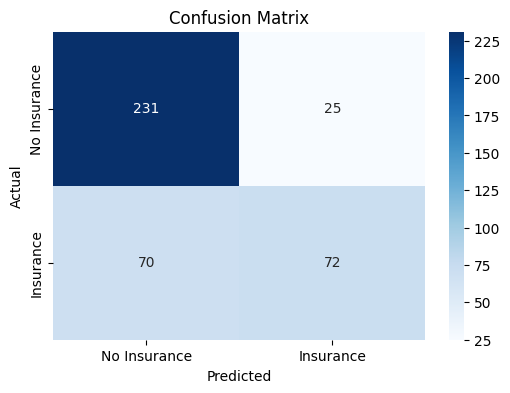

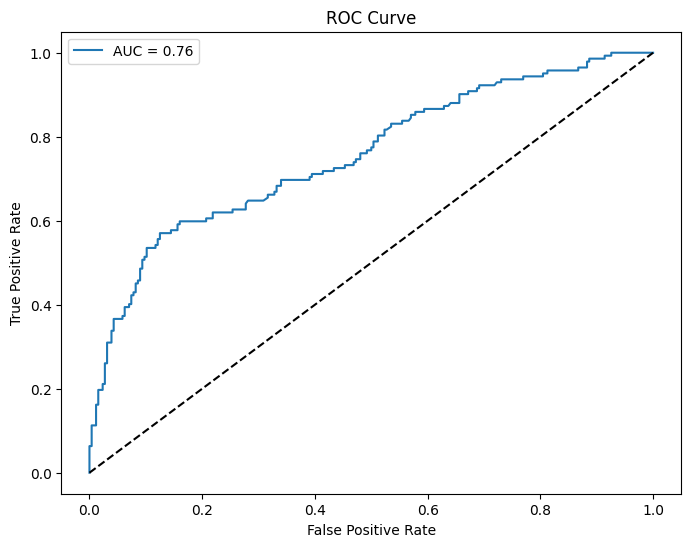


Feature Coefficients:
               Feature  Coefficient
1         AnnualIncome     2.324855
7  EverTravelledAbroad     1.792918
2        FamilyMembers     1.019693
0                  Age     0.781633
6        FrequentFlyer     0.416515
5      ChronicDiseases     0.104970
4        GraduateOrNot    -0.125117
3       EmploymentType    -0.198147


In [38]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

param_dist = {
    "classifier__C": uniform(0.001, 100),
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Insurance", "Insurance"],
    yticklabels=["No Insurance", "Insurance"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

feature_names = continuous_vars + binary_vars
coefficients = best_model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
).sort_values("Coefficient", ascending=False)

print("\nFeature Coefficients:")
print(coef_df)

## Decision Tree Model
As seen below, a decision tree model gives an:
- *AUC = 0.763.* This is a decent figure.
- *Accuracy = 0.807.* This is a decent figure., and noticeably better than before.
- *The case of **no** insurance being bought - recall of 0.95 and precision of = 0.79.* This is a very high recall, and a decent precision, which is good.
- *The case of insurance **being** bought - recall of 0.56 and precision of 0.85.* This is still a poor rate of recall, albeit higher than the previous model.
- Macro average F1 score = 0.77. This is a slightly low level of predictive power.
- Performs **better** than a stratified dummy classifier, with the dummy showing an AUC of 0.528.

Here, the coefficient which are shown to hold the highest importance is by far AnnualIncome, with the rest of the variables far less impactful. 

This again indicates support for the hypothesis to be true.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}

Best cross-validation AUC score: 0.820

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       256
           1       0.85      0.56      0.67       142

    accuracy                           0.81       398
   macro avg       0.82      0.75      0.77       398
weighted avg       0.81      0.81      0.79       398


Test AUC: 0.763
Test Accuracy: 0.807


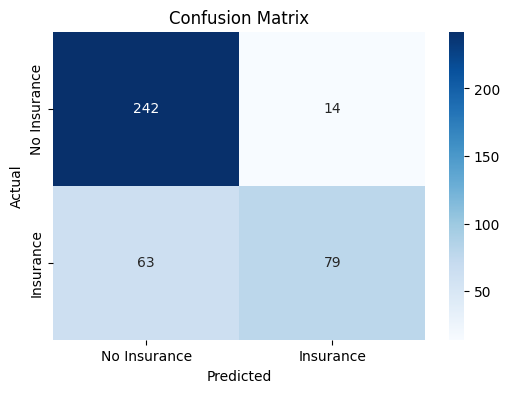

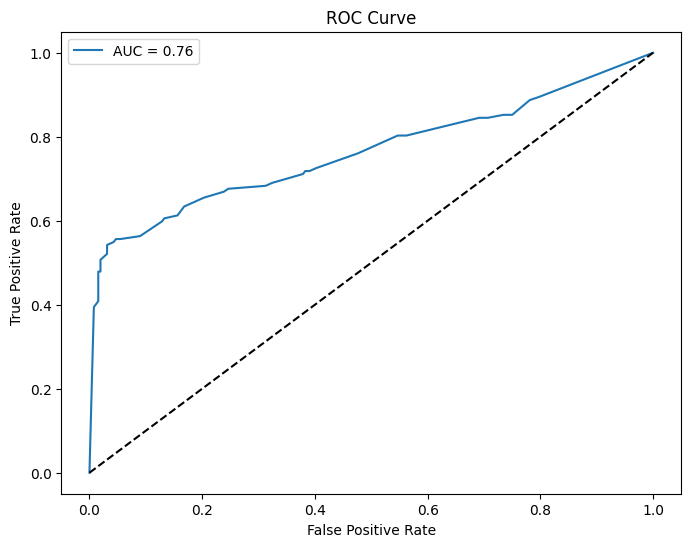


Feature Importances:
               Feature  Importance
1         AnnualIncome    0.656426
2        FamilyMembers    0.191615
0                  Age    0.109023
5      ChronicDiseases    0.022574
6        FrequentFlyer    0.009180
4        GraduateOrNot    0.004951
7  EverTravelledAbroad    0.003540
3       EmploymentType    0.002692


In [31]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

param_dist = {
    "classifier__max_depth": randint(2, 20),
    "classifier__min_samples_split": randint(2, 20),
    "classifier__min_samples_leaf": randint(1, 20),
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Insurance", "Insurance"],
    yticklabels=["No Insurance", "Insurance"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

importances = best_model.named_steps["classifier"].feature_importances_
feature_names = continuous_vars + binary_vars

importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importances_df)

## Support Vector Machine Model

As seen below, a support vector machine model gives an:
- *AUC = 0.760.* This is a decent figure, which is *slightly* better than the logistic regression.
- *Accuracy = 0.781.* This is a decent figure.
- *The case of **no** insurance being bought - recall of 0.89 and precision of = 0.79.* This is a very high recall, and a decent precision, which is good.
- *The case of insurance **being** bought - recall of 0.58 and precision of 0.75.* This is still a poor rate of recall, albeit higher than the previous model.
- *Macro average F1 score = 0.75.* This is a slightly higher level of predictive power.
- Performs **better** than a stratified dummy classifier, with the dummy showing an AUC of 0.528.

Here, as we are using rbf, we cannot access the same type of coefficients as earlier.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__C': np.float64(27.135903177389594), 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

Best cross-validation AUC score: 0.800

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       256
           1       0.75      0.58      0.65       142

    accuracy                           0.78       398
   macro avg       0.77      0.74      0.75       398
weighted avg       0.78      0.78      0.77       398


Test AUC: 0.760
Test Accuracy: 0.781


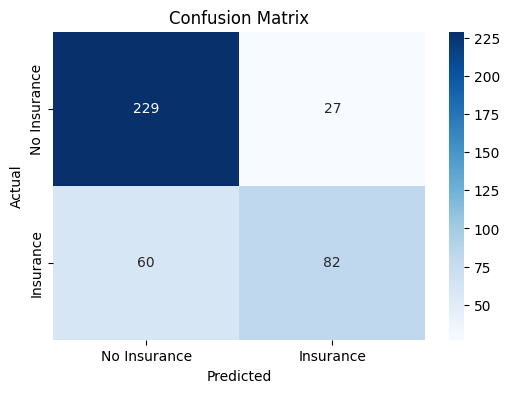

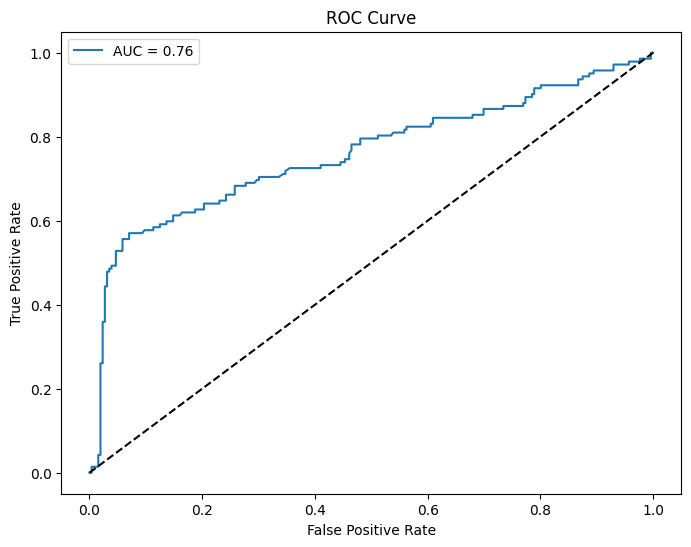


Feature coefficients are only available for linear kernel
Selected kernel: rbf


In [32]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", SVC(random_state=42, probability=True)),
    ]
)

param_dist = {
    "classifier__C": uniform(0.001, 100),
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__gamma": ["scale", "auto"],
    "classifier__class_weight": ["balanced"],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Insurance", "Insurance"],
    yticklabels=["No Insurance", "Insurance"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

if random_search.best_params_["classifier__kernel"] == "linear":
    feature_names = continuous_vars + binary_vars
    coefficients = best_model.named_steps["classifier"].coef_[0]

    coef_df = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": coefficients}
    ).sort_values("Coefficient", ascending=False)

    print("\nFeature Coefficients:")
    print(coef_df)
else:
    print("\nFeature coefficients are only available for linear kernel")
    print("Selected kernel:", random_search.best_params_["classifier__kernel"])

## Naive Bayes Model
As seen below, a Naive Bayes model gives an:
- *AUC = 0.730.* This is a decent figure, which is *slightly* lower than the previous two model.
- *Accuracy = 0.744.* This is a decent figure.
- *The case of **no** insurance being bought - recall of 0.86 and precision of = 0.77.* This is a very high recall, and a decent precision, which is good.
- *The case of insurance **being** bought - recall of 0.58 and precision of 0.68.* This is still a poor rate of recall.
- *Macro average F1 score = 0.71.* This is a slightly higher level of predictive power.
- Performs **better** than a stratified dummy classifier, with the dummy showing an AUC of 0.528.

Interestingly, the mean feature placed on the coefficients are as follows; 1) GraduateOrNot  (0.843291); 2) Age  (0.446033); 3) FamilyMembers  (0.380719); 4) EmploymentType  (0.348678); 5) AnnualIncome  (0.343715); 6) ChronicDiseases  (0.267385); 7) FrequentFlyer  (0.140059); 8) EverTravelledAbroad  (0.058766). This hierarchy is also quite different to what the inferential model indicated, particularly in the case of the binary variables.

This does not indicate support for the hypothesis to be true.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__var_smoothing': np.float64(0.001)}

Best cross-validation AUC score: 0.750

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       256
           1       0.68      0.54      0.60       142

    accuracy                           0.74       398
   macro avg       0.72      0.70      0.71       398
weighted avg       0.74      0.74      0.74       398


Test AUC: 0.730
Test Accuracy: 0.744


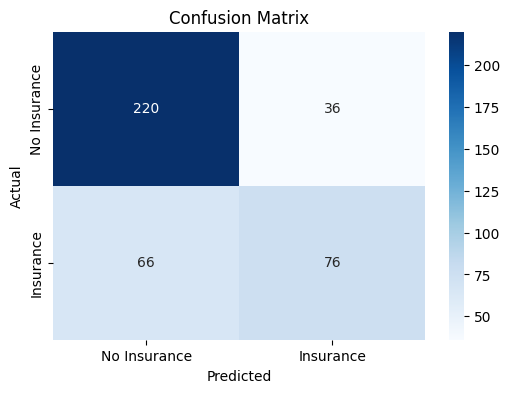

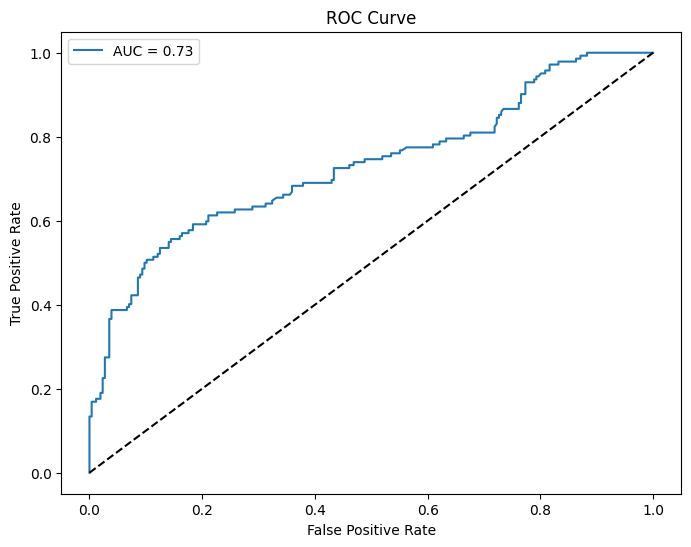


Feature Means:
               Feature      Mean
4        GraduateOrNot  0.843291
0                  Age  0.446033
2        FamilyMembers  0.380719
3       EmploymentType  0.348678
1         AnnualIncome  0.343715
5      ChronicDiseases  0.267385
6        FrequentFlyer  0.140059
7  EverTravelledAbroad  0.058766

Feature Variances:
               Feature  Variance
3       EmploymentType  0.227309
5      ChronicDiseases  0.196097
4        GraduateOrNot  0.132359
6        FrequentFlyer  0.120650
0                  Age  0.069724
7  EverTravelledAbroad  0.055520
2        FamilyMembers  0.050207
1         AnnualIncome  0.048533


In [33]:
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", GaussianNB())])

param_dist = {"classifier__var_smoothing": np.logspace(0, -9, num=100)}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5),
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Insurance", "Insurance"],
    yticklabels=["No Insurance", "Insurance"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

if hasattr(best_model.named_steps["classifier"], "theta_"):
    feature_names = continuous_vars + binary_vars
    means = best_model.named_steps["classifier"].theta_[0]

    # Use var_ instead of sigma_
    variances = best_model.named_steps["classifier"].var_[0]

    means_df = pd.DataFrame({"Feature": feature_names, "Mean": means}).sort_values(
        "Mean", ascending=False
    )

    variances_df = pd.DataFrame(
        {"Feature": feature_names, "Variance": variances}
    ).sort_values("Variance", ascending=False)

    print("\nFeature Means:")
    print(means_df)
    print("\nFeature Variances:")
    print(variances_df)
else:
    print("\nFeature statistics not available for this model")

# Ensemble Models

## Random Forest Model
As seen below, a Random Forest model gives an:
- *AUC = 0.771.* This is a decent figure, which is higher than all previous models.
- *Accuracy = 0.802.* This is a good figure, and also the highest of previous models.
- *The case of **no** insurance being bought - recall of 0.92 and precision of = 0.80.* This is a very high recall, and a decent precision, which is good. In fact, this is the best so far.
- *The case of insurance **being** bought - recall of 0.58 and precision of 0.81.* This is still a poor rate of recall, but higher than other models.
- *Macro average F1 score = 0.77.* This is also a higher level of predictive power.
- Performs **better** than a stratified dummy classifier, with the dummy showing an AUC of 0.528.

The coefficients also here mirror the original hierarchy more, with AnnualIncome (importance score of 0.558) taking up the vast majority of influence compared to other coefficients (the next highest is FamilyMembers, with 0.199).

This again indicates support for the hypothesis to be true.

Performing randomized search with cross-validation...

Best parameters found:
{'classifier__n_estimators': 50, 'classifier__min_samples_split': 5, 'classifier__max_features': None, 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced'}

Best cross-validation AUC score: 0.817

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       256
           1       0.81      0.58      0.68       142

    accuracy                           0.80       398
   macro avg       0.80      0.75      0.77       398
weighted avg       0.80      0.80      0.79       398


Test AUC: 0.771
Test Accuracy: 0.802


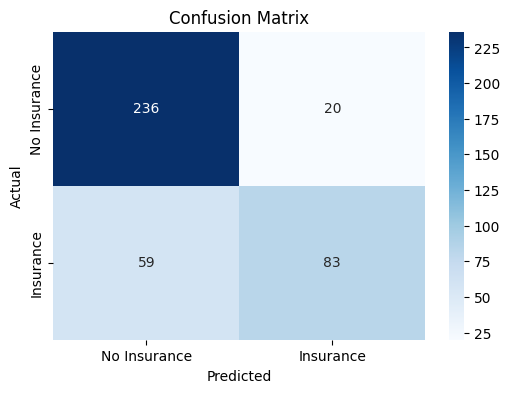

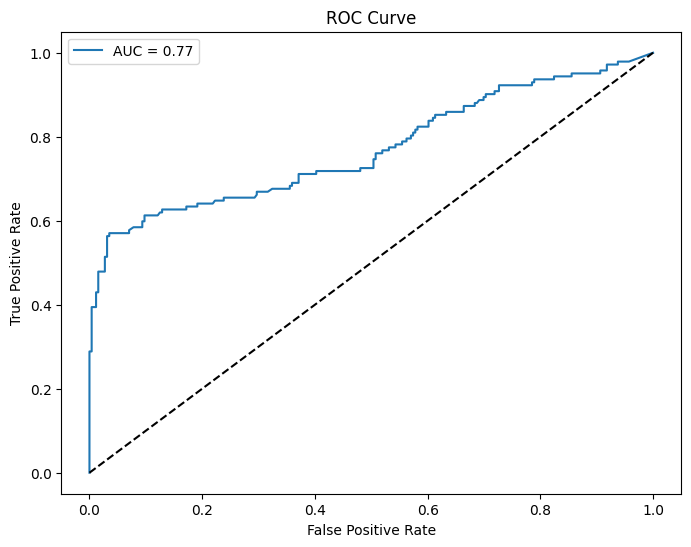


Feature Importances:
               Feature  Importance
1         AnnualIncome    0.558127
2        FamilyMembers    0.198643
0                  Age    0.144691
5      ChronicDiseases    0.028440
6        FrequentFlyer    0.026519
4        GraduateOrNot    0.015235
3       EmploymentType    0.014217
7  EverTravelledAbroad    0.014129


In [34]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

param_dist = {
    "classifier__n_estimators": [50, 100, 200],  # Number of trees
    "classifier__max_depth": [None, 5, 10, 20],  # Maximum depth of trees
    "classifier__min_samples_split": [2, 5, 10],  # Minimum samples to split
    "classifier__class_weight": ["balanced", None],  # Class weight for imbalanced data
    "classifier__max_features": [
        "sqrt",
        "log2",
        None,
    ],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)

print("Performing randomized search with cross-validation...")
random_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation AUC score: {random_search.best_score_:.3f}")

best_model = random_search.best_estimator_

print("\nEvaluating on test set...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Insurance", "Insurance"],
    yticklabels=["No Insurance", "Insurance"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

feature_names = continuous_vars + binary_vars
importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

## Voting Model
Lastly, as seen below, an ensemble model combining the logistic regression, the SVM, and the random forest gives an:
- *AUC = 0.786.* This is a decent figure, which is higher than all previous models.
- *Accuracy = 0.802.* This is a good figure, and also the highest of previous models.
- *The case of **no** insurance being bought - recall of 0.92 and precision of = 0.78.* This is a very high recall, and a decent precision, which is good.
- *The case of insurance **being** bought - recall of 0.56 and precision of 0.82.* This is still a poor rate of recall, but higher than other models except the random forest.
- *Macro average F1 score = 0.76.* This is also a higher level of predictive power.
- Performs **better** than a stratified dummy classifier, with the dummy showing an AUC of 0.528.

Training voting classifier...

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       256
           1       0.82      0.56      0.67       142

    accuracy                           0.80       398
   macro avg       0.81      0.75      0.76       398
weighted avg       0.80      0.80      0.79       398


Test AUC: 0.786
Test Accuracy: 0.802


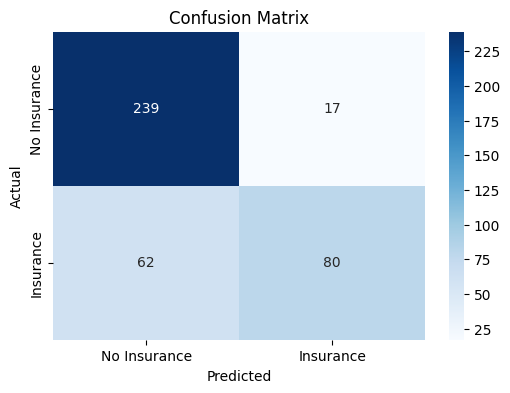

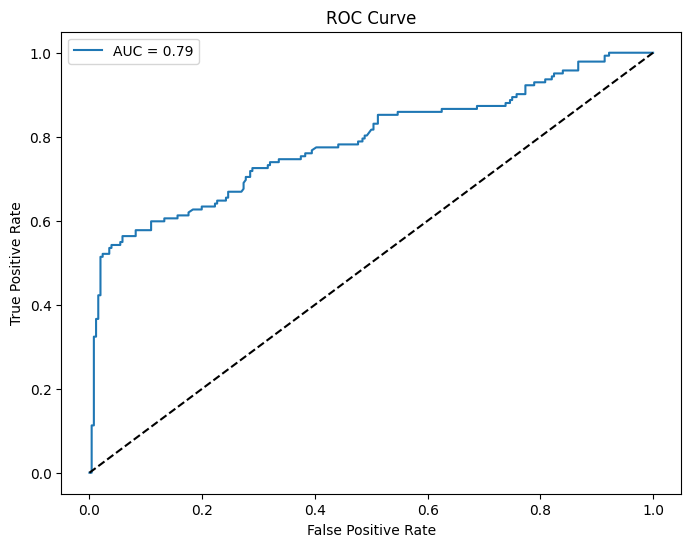

In [35]:
logistic = LogisticRegression(
    C=33.371861113902185,
    penalty="l2",
    solver="liblinear",
    random_state=42,
    max_iter=1000,
)

svm = SVC(
    C=27.135903177389594,
    kernel="rbf",
    gamma="scale",
    class_weight="balanced",
    probability=True,
    random_state=42,
)

random_forest = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    max_features=None,
    class_weight="balanced",
    random_state=42,
)

voting_clf = VotingClassifier(
    estimators=[("lr", logistic), ("svc", svm), ("rf", random_forest)],
    voting="soft",
    weights=None,
)

pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", voting_clf)])

print("Training voting classifier...")
pipeline.fit(X_train, y_train)

print("\nEvaluating on test set...")
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Insurance", "Insurance"],
    yticklabels=["No Insurance", "Insurance"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Conclusion
In this report, I first ran an inferential model to investigate which variables are significant and are  variety of different machine learning models to maximize predictive power. With this in mind, I then ran a series of different machine learning classification models to optimize for predictive power. I also tuned the hyperparameters to find the best fit. 
Ultimately, the models that performed the best were both ensemble models, namely; 1) a random forest model, and; 2) a voting classifier reliant on a logistic regression, an SVM, and a random forest. While each one has incredibly slight advantages over the other, the differences are negligible. However, it can be said that the the voting classifier is a lot more demanding than the random forest, and as such, this is perhaps the strongest argument for this being the best model overall of the ones tried here. 
It can also be said that most machine learning models, as well as the inferential model, shows the income of a respondent to be the strongest decider of whether someone buys an insurance. As such, this analysis shows support for the hypothesis.

### Points of improvement
As one can see, the recall for the positive case of the response variable is rather low (around 0.6). This is, however, often the case for datasets that have an imbalance of cases as this dataset does - this is also why we used a stratified split in hopes of maximizing the representation of these cases in the split itself. Depending on the business context, it could be valuable to maximize the recall for this specific case. If this was a goal, we could seek to increase recall at the cost of precision, such as by reducing the threshold by which a case gets assigned to the case, adding class weights to this specific case to penalize the model more when getting this specific case wrong, or by resampling the underrepresented case (e.g., through SMOTE). However, I should say that I tried these methods for specific models, and only faced marginal increases in recall ability while having a disproportionately more negative effect on precision.
Furthermore, one could run a larger array of different models to try to maximize predictive power. Due to myself still being a learner, I restricted myself to the models at hand.
Other things that could have been improved:
- Take up less space with unique value checks
- Create functions for plots and model summaries and store them in a utilities.py
- Get binary values without hardcoding
- Divide notebook into two - one for EDA, and one for modelling.

☼ Print only head() ☼ Try taking up less space with unique value check ☼ Create functions for plots and model summaries ☼ Write down more insights ☼ Get binary values without hardcoding ☼ Create the final table with all of the results